In [1]:
using Pkg; Pkg.activate("../."); Pkg.instantiate()
using Plots; gr()
using SparseArrays
using Statistics
using ModelingToolkit
using LinearAlgebra
using HDF5
using JLD
using Infiltrator
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using DiffEqOperators
using Tullio

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


In [2]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.01
t₁ = 1

D₀ = 1
tolnl = 1e-4
itMax = 100
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1

0.24390243902439027

In [3]:
function loss(T, θ, p)
    
    uD = θ[1]
    
    T = heatflow(T, uD, p)

    l_H = sqrt(Flux.Losses.mse(T, T₁; agg=mean))

    return l_H
end

loss (generic function with 1 method)

In [4]:
function heatflow(T, D::Real, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 2 methods)

In [5]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

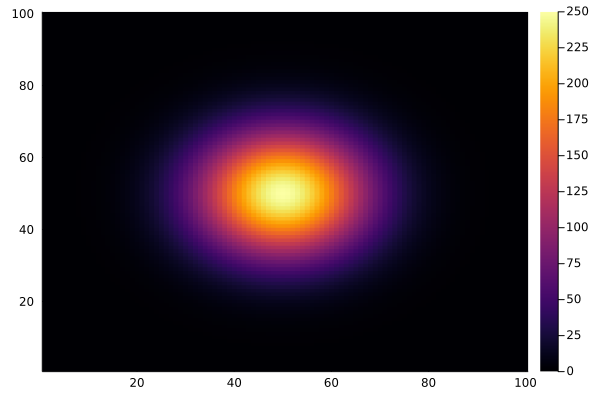

In [6]:
p = (Δx, Δy, Δt, t₁)

T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

T₁ = copy(T₀)
T₁ = heatflow(T₁, D₀, p, 1e-1)

heatmap(T₀, clim=(0, maximum(T₀)))

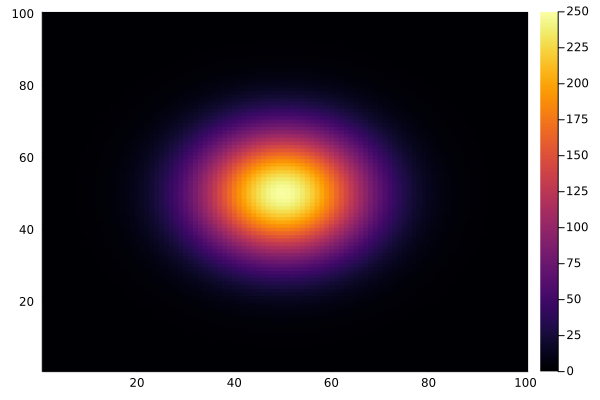

In [7]:
heatmap(T₁, clim=(0, maximum(T₀)))

In [8]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

0.16311579618178718

In [9]:
T = copy(T₀)

loss_uD, back_uD = Zygote.pullback(D -> loss(T, [D], p), 100)

(2.9749888654073713, Zygote.var"#41#42"{typeof(∂(#20))}(∂(#20)))

In [10]:
#all_D = 10 .^ LinRange(-4, 5, 100)
all_D = LinRange(D₀/2, 2D₀, 100)
all_loss = zeros(0)
all_grad = zeros(0)

for d in all_D
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(D -> loss(T, D, p), d)
    
    # println(d)
    # println(loss_uD, back_uD(1))
    
    append!(all_loss, loss_uD)
    append!(all_grad, back_uD(1)[1])
end

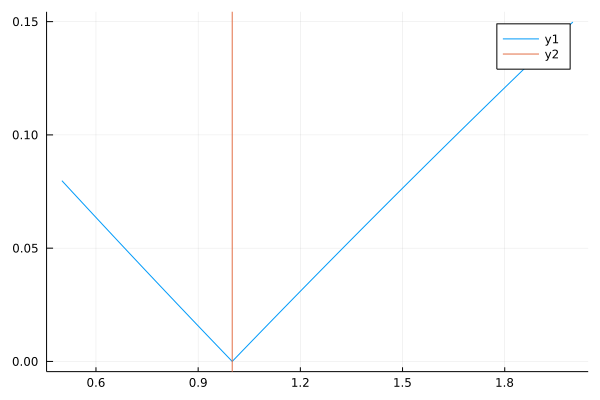

In [11]:
plot(all_D, all_loss)
vline!([D₀])

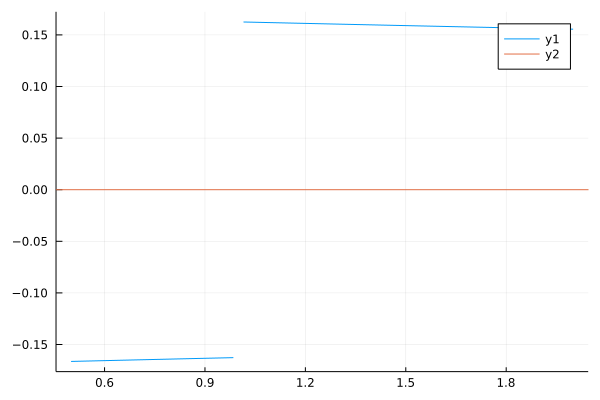

In [12]:
plot(all_D, all_grad)
hline!([0])

### Optimization on D

In [13]:
#Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

In [13]:
function train(loss, p)
    
    θ = [10.]

    opt = ADAM(0.1)
    @epochs 100 hybrid_train!(loss, θ, p, opt)
    
    return θ
    
end

function hybrid_train!(loss, θ, p, opt)
        
    T = T₀
    loss_uD, back_uD = Zygote.pullback(θ -> loss(T, θ, p), θ)
    
    ∇_uD = back_uD(one(loss_uD))[1]
    
    println("Loss: ", loss_uD)
    println("Current parameter: ", θ)
    println("Gradient: ", ∇_uD)
    println("opt: ", opt)
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
end

hybrid_train! (generic function with 1 method)

In [14]:
θ₁ = train(loss, p)
D = θ₁[1]

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 1.0174505165728547
Current parameter: [10.0]
Gradient: [0.11536990922261617]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}())


┌ Info: Epoch 2
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 1.0092430554727407
Current parameter: [9.90000000866777]
Gradient: [0.11574379097738677]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([9.90000000866777] => ([0.011536990922261615], [1.3310215954034707e-5], (0.81, 0.998001))))


┌ Info: Epoch 3
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 1.000984217462333
Current parameter: [9.799991714702806]
Gradient: [0.11612012991088633]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([9.799991714702806] => ([0.021957670927774127], [2.6693530887897682e-5], (0.7290000000000001, 0.997002999))))


┌ Info: Epoch 4
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.9926730559255894
Current parameter: [9.699969566640052]
Gradient: [0.11649897136986294]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([9.699969566640052] => ([0.03137391682608535], [4.015072192753091e-5], (0.6561000000000001, 0.996005996001))))


┌ Info: Epoch 5
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.9843086067528766
Current parameter: [9.59992801452714]
Gradient: [0.11688036156701767]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([9.59992801452714] => ([0.0398864222804631], [5.3682581535839535e-5], (0.5904900000000002, 0.995009990004999))))


┌ Info: Epoch 6
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.975889888890651
Current parameter: [9.499861520788754]
Gradient: [0.1172643475580603]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([9.499861520788754] => ([0.04758581620911856], [6.72899178743405e-5], (0.5314410000000002, 0.994014980014994))))


┌ Info: Epoch 7
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.9674159048943285
Current parameter: [9.399764570843653]
Gradient: [0.11765097721861406]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([9.399764570843653] => ([0.054553669344012734], [8.097355516468373e-5], (0.47829690000000014, 0.993020965034979))))


┌ Info: Epoch 8
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.9588856414771495
Current parameter: [9.29963168339345]
Gradient: [0.11804029922129446]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([9.29963168339345] => ([0.06086340013147286], [9.47343340500139e-5], (0.43046721000000016, 0.9920279440699441))))


┌ Info: Epoch 9
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.9502980700483148
Current parameter: [9.199457420307438]
Gradient: [0.11843236301326979]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([9.199457420307438] => ([0.06658109004045501], [0.00010857311195621663], (0.38742048900000015, 0.9910359161258742))))


┌ Info: Epoch 10
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.9416521472335998
Current parameter: [9.099236396034003]
Gradient: [0.11882721879462015]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([9.099236396034003] => ([0.07176621733773648], [0.00012249076345316733], (0.34867844010000015, 0.9900448802097482))))


┌ Info: Epoch 11
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.9329468153721474
Current parameter: [8.998963286476314]
Gradient: [0.11922491749777182]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([8.998963286476314] => ([0.07647231748342485], [0.0001364881806161787], (0.31381059609000017, 0.9890548353295385))))


┌ Info: Epoch 12
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.9241810029833616
Current parameter: [8.898632837277768]
Gradient: [0.11962551076830223]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([8.898632837277768] => ([0.08074757748485954], [0.00015056627338791304], (0.28242953648100017, 0.988065780494209))))


┌ Info: Epoch 13
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.9153536251984622
Current parameter: [8.798239871471065]
Gradient: [0.12002905094735705]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([8.798239871471065] => ([0.08463537081320381], [0.00016472596994110232], (0.25418658283290013, 0.9870777147137147))))


┌ Info: Epoch 14
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.9064635841515675
Current parameter: [8.697779296453495]
Gradient: [0.12043559105592026]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([8.697779296453495] => ([0.08817473882661914], [0.00017896821704248446], (0.22876792454961012, 0.986090636999001))))


┌ Info: Epoch 15
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8975097693259523
Current parameter: [8.597246110259919]
Gradient: [0.12084518478114278]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([8.597246110259919] => ([0.09140082404954925], [0.00019329398041843083], (0.2058911320946491, 0.9851045463620021))))


┌ Info: Epoch 16
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8884910578515329
Current parameter: [8.496635407113752]
Gradient: [0.12125788646491092]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([8.496635407113752] => ([0.0943452601227086], [0.00020770424512280095], (0.1853020188851842, 0.98411944181564))))


┌ Info: Epoch 17
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8794063147503198
Current parameter: [8.395942382245028]
Gradient: [0.12167375109481715]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([8.395942382245028] => ([0.09703652275692883], [0.00022220001590761537], (0.16677181699666577, 0.9831353223738244))))


┌ Info: Epoch 18
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8702543931273489
Current parameter: [8.295162335972911]
Gradient: [0.12209283429764241]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([8.295162335972911] => ([0.09950024559071766], [0.0002367823175971913], (0.1500946352969992, 0.9821521870514506))))


┌ Info: Epoch 19
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8610341343048719
Current parameter: [8.194290677057994]
Gradient: [0.1225151923354665]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([8.194290677057994] => ([0.10175950446141013], [0.0002514521954664257], (0.13508517176729928, 0.9811700348643991))))


┌ Info: Epoch 20
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8517443678985414
Current parameter: [8.093322925337013]
Gradient: [0.12294088210446674]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([8.093322925337013] => ([0.10383507324881576], [0.0002662107156239556], (0.12157665459056936, 0.9801888648295347))))


┌ Info: Epoch 21
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8423839118347282
Current parameter: [7.992254713659276]
Gradient: [0.12336996113645501]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([7.992254713659276] => ([0.10574565413438085], [0.00028105896540095605], (0.10941898913151243, 0.9792086759647052))))


┌ Info: Epoch 22
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8329515723086112
Current parameter: [7.8910817891500455]
Gradient: [0.1238024876031723]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([7.8910817891500455] => ([0.10750808483458826], [0.00029599805374636555], (0.0984770902183612, 0.9782294672887405))))


┌ Info: Epoch 23
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8234461436832983
Current parameter: [7.789800013831234]
Gradient: [0.12423852032333978]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([7.789800013831234] => ([0.10913752511144666], [0.00031102911162935284], (0.08862938119652508, 0.9772512378214517))))


┌ Info: Epoch 24
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8138664083305948
Current parameter: [7.688405364634118]
Gradient: [0.12467811877244642]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([7.688405364634118] => ([0.11064762463263597], [0.0003261532924498564], (0.07976644307687257, 0.9762739865836303))))


┌ Info: Epoch 25
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.8042111364144593
Current parameter: [7.586893932842286]
Gradient: [0.12512134309523296]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([7.586893932842286] => ([0.112050674046617], [0.0003413717724580428], (0.07178979876918531, 0.9752977125970467))))


┌ Info: Epoch 26
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.7944790856185391
Current parameter: [7.485261923005754]
Gradient: [0.12556825412081]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([7.485261923005754] => ([0.1133577409514786], [0.0003566857511835398], (0.06461081889226679, 0.9743224148844496))))


┌ Info: Epoch 27
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.7846690008194193
Current parameter: [7.383505651369119]
Gradient: [0.1260189133803563]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([7.383505651369119] => ([0.11457879226841175], [0.0003720964518753045], (0.05814973700304011, 0.9733480924695651))))


┌ Info: Epoch 28
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.7747796137075073
Current parameter: [7.281621543857833]
Gradient: [0.12647338312730386]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([7.281621543857833] => ([0.1157228043796062], [0.00038760512195299497], (0.0523347633027361, 0.9723747443770956))))


┌ Info: Epoch 29
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.7648096423576767
Current parameter: [7.179606133667205]
Gradient: [0.12693172635992758]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([7.179606133667205] => ([0.11679786225437597], [0.0004032130334707078], (0.04710128697246249, 0.9714023696327185))))


┌ Info: Epoch 30
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.7547577907517536
Current parameter: [7.077456058498651]
Gradient: [0.1273940068462542]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([7.077456058498651] => ([0.11781124866493113], [0.00041892148359394863], (0.042391158275216244, 0.9704309672630859))))


┌ Info: Epoch 31
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.7446227482552302
Current parameter: [6.9751680574870685]
Gradient: [0.1278602891511771]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([6.9751680574870685] => ([0.11876952448306344], [0.0004347317950906982], (0.03815204244769462, 0.9694605362958227))))


┌ Info: Epoch 32
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.7344031890504755
Current parameter: [6.872738967862082]
Gradient: [0.12833063866569716]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([6.872738967862082] => ([0.1196786009498748], [0.00045064531683743016], (0.03433683820292516, 0.9684910757595269))))


┌ Info: Epoch 33
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.7240977715287297
Current parameter: [6.770165721384373]
Gradient: [0.1288051216381799]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([6.770165721384373] => ([0.12054380472145704], [0.00046666342434093845], (0.030903154382632643, 0.9675225846837673))))


┌ Info: Epoch 34
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.7137051376431949
Current parameter: [6.667445340596422]
Gradient: [0.12928380520753321]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([6.667445340596422] => ([0.12136993641312932], [0.00048278752027682383], (0.02781283894436938, 0.9665550620990835))))


┌ Info: Epoch 35
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.7032239122253339
Current parameter: [6.564574934924836]
Gradient: [0.12976675743822283]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([6.564574934924836] => ([0.1221613232925697], [0.0004990190350454864], (0.025031555049932444, 0.9655885070369844))))


┌ Info: Epoch 36
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.6926527022664732
Current parameter: [6.461551696669071]
Gradient: [0.1302540473570288]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([6.461551696669071] => ([0.12292186670713501], [0.0005153594273464715], (0.0225283995449392, 0.9646229185299474))))


┌ Info: Epoch 37
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.6819900961667207
Current parameter: [6.358372896908847]
Gradient: [0.13074574499146185]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([6.358372896908847] => ([0.12365508477212439], [0.0005318101847720122], (0.020275559590445278, 0.9636582956114175))))


┌ Info: Epoch 38
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.6712346629529031
Current parameter: [6.255035881359938]
Gradient: [0.13124192140977076]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([6.255035881359938] => ([0.12436415079405815], [0.0005483728244206126], (0.01824800363140075, 0.9626946373158061))))


┌ Info: Epoch 39
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.6603849514672276
Current parameter: [6.151538066205377]
Gradient: [0.1317426487624663]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([6.151538066205377] => ([0.1250519278556294], [0.0005650488935315204], (0.016423203268260675, 0.9617319426784903))))


┌ Info: Epoch 40
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.6494394895281255
Current parameter: [6.047876933926437]
Gradient: [0.132248000325309]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([6.047876933926437] => ([0.1257209999463131], [0.0005818399701409395], (0.014780882941434608, 0.9607702107358118))))


┌ Info: Epoch 41
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.638396783064519
Current parameter: [5.944050029155176]
Gradient: [0.13275805054370077]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([5.944050029155176] => ([0.1263736999842127], [0.0005987476637608415], (0.013302794647291147, 0.959809440525076))))


┌ Info: Epoch 42
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.6272553152247229
Current parameter: [5.840054954567716]
Gradient: [0.13327287507844832]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([5.840054954567716] => ([0.12701213504016148], [0.0006157736160812444], (0.011972515182562033, 0.9588496310845509))))


┌ Info: Epoch 43
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.616013545460735
Current parameter: [5.735889366835034]
Gradient: [0.13379255085285563]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([5.735889366835034] => ([0.12763820904399015], [0.0006329195016968388], (0.01077526366430583, 0.9578907814534664))))


┌ Info: Epoch 44
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.6046699085887706
Current parameter: [5.631550972645652]
Gradient: [0.13431715610112585]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([5.631550972645652] => ([0.1282536432248767], [0.0006501870288588559], (0.009697737297875247, 0.9569328906720129))))


┌ Info: Epoch 45
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.5932228138265676
Current parameter: [5.527037524812427]
Gradient: [0.1348467704180567]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([5.527037524812427] => ([0.12885999451250163], [0.0006675779402530914], (0.008727963568087723, 0.9559759577813409))))


┌ Info: Epoch 46
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.5816706438076745
Current parameter: [5.422346818473553]
Gradient: [0.13538147481001767]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([5.422346818473553] => ([0.12945867210305714], [0.0006850940138050185], (0.00785516721127895, 0.9550199818235596))))


┌ Info: Epoch 47
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.5700117535731217
Current parameter: [5.317476687395971]
Gradient: [0.13592135174721742]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([5.317476687395971] => ([0.1300509523737532], [0.0007027370635129489], (0.007069650490151055, 0.9540649618417361))))


┌ Info: Epoch 48
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.5582444695403038
Current parameter: [5.212425000387627]
Gradient: [0.13646648521726257]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([5.212425000387627] => ([0.1306379923110996], [0.0007205089403102267], (0.00636268544113595, 0.9531108968798944))))


┌ Info: Epoch 49
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.5463670884489249
Current parameter: [5.107189657823373]
Gradient: [0.1370169607800342]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([5.107189657823373] => ([0.1312208416017159], [0.0007384115329574698], (0.005726416897022355, 0.9521577859830145))))


┌ Info: Epoch 50
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.5343778762837998
Current parameter: [5.00176858828787]
Gradient: [0.13757286562390098]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([5.00176858828787] => ([0.13180045351954772], [0.0007564467689659099], (0.00515377520732012, 0.9512056281970315))))


┌ Info: Epoch 51
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.5222750671738511
Current parameter: [4.8961597453375445]
Gradient: [0.13813428862330554]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([4.8961597453375445] => ([0.13237769472998304], [0.0007746166155529159], (0.004638397686588107, 0.9502544225688344))))


┌ Info: Epoch 52
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.5100568622668403
Current parameter: [4.790361104382433]
Gradient: [0.13870132039776575]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([4.790361104382433] => ([0.13295335411931528], [0.0007929230806308297], (0.0041745579179292966, 0.9493041681462656))))


┌ Info: Epoch 53
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.49772142857890944
Current parameter: [4.6843706596877945]
Gradient: [0.13927405337233165]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([4.6843706596877945] => ([0.13352815074716032], [0.0008113682138302825], (0.003757102126136367, 0.9483548639781193))))


┌ Info: Epoch 54
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.48526689781813936
Current parameter: [4.578186421494392]
Gradient: [0.13985258183956428]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([4.578186421494392] => ([0.13410274100967745], [0.0008299541075592114], (0.00338139191352273, 0.9474065091141411))))


┌ Info: Epoch 55
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.4726913651810336
Current parameter: [4.471806413255624]
Gradient: [0.14043700202308693]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([4.471806413255624] => ([0.13467772509266612], [0.0008486828980988442], (0.0030432527221704573, 0.946459102605027))))


┌ Info: Epoch 56
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.4599928881207269
Current parameter: [4.365228668988988]
Gradient: [0.1410274121427785]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([4.365228668988988] => ([0.13525365278570822], [0.0008675567667379779], (0.0027389274499534117, 0.9455126435024219))))


┌ Info: Epoch 57
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.44716948508574406
Current parameter: [4.258451230738797]
Gradient: [0.14162391248169046]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([4.258451230738797] => ([0.13583102872141525], [0.000886577940946929], (0.0024650347049580707, 0.9445671308589195))))


┌ Info: Epoch 58
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.4342191342277734
Current parameter: [4.151472146146626]
Gradient: [0.14222660545475663]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([4.151472146146626] => ([0.13641031709744278], [0.0009057486955926036], (0.0022185312344622636, 0.9436225637280606))))


┌ Info: Epoch 59
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.42113977207705067
Current parameter: [4.044289466125555]
Gradient: [0.14283559567938764]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([4.044289466125555] => ([0.13699194593317415], [0.000925071354196194], (0.001996678111016037, 0.9426789411643326))))


┌ Info: Epoch 60
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.4079292921836818
Current parameter: [3.936901242633988]
Gradient: [0.14345099004804288]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([3.936901242633988] => ([0.1375763109077955], [0.0009445482902350833], (0.0017970102999144335, 0.9417362622231683))))


┌ Info: Epoch 61
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.3945855437231879
Current parameter: [3.8293055265446014]
Gradient: [0.14407289780287275]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([3.8293055265446014] => ([0.13816377882182027], [0.0009641819284906119], (0.0016173092699229901, 0.9407945259609451))))


┌ Info: Epoch 62
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.3811063300643942
Current parameter: [3.721500365603781]
Gradient: [0.14470143061254093]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([3.721500365603781] => ([0.13875469071992552], [0.0009839747464434384], (0.0014555783429306911, 0.9398537314349842))))


┌ Info: Epoch 63
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.3674894072978621
Current parameter: [3.6134838024768117]
Gradient: [0.14533670265132995]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([3.6134838024768117] => ([0.13934936470918707], [0.001003929275718311], (0.001310020508637622, 0.9389138777035492))))


┌ Info: Epoch 64
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.35373248272260605
Current parameter: [3.505253872874]
Gradient: [0.14597883068064982]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([3.505253872874] => ([0.13994809850340137], [0.0010240481035801538], (0.0011790184577738598, 0.9379749638258457))))


┌ Info: Epoch 65
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.3398332132891609
Current parameter: [3.396808603752889]
Gradient: [0.14662793413307287]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([3.396808603752889] => ([0.14055117172112622], [0.0010443338744834634], (0.0010611166119964739, 0.9370369888620198))))


┌ Info: Epoch 66
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.3257892039966169
Current parameter: [3.2881460115917256]
Gradient: [0.14728413519901434]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([3.2881460115917256] => ([0.1411588479623209], [0.0010647892916771128], (0.0009550049507968265, 0.9360999518731578))))


┌ Info: Epoch 67
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.3115980062412614
Current parameter: [3.1792641007293794]
Gradient: [0.1479475589162014]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([3.1792641007293794] => ([0.14177137668599024], [0.0010854171188667571], (0.0008595044557171439, 0.9351638519212846))))


┌ Info: Epoch 68
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.29725711611444083
Current parameter: [3.070160861766972]
Gradient: [0.14861833326206844]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([3.070160861766972] => ([0.14238899490901136], [0.0011062201819371533], (0.0007735540101454295, 0.9342286880693633))))


┌ Info: Epoch 69
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.2827639726469727
Current parameter: [2.9608342700265595]
Gradient: [0.14929658924922484]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([2.9608342700265595] => ([0.14301192874431706], [0.0011272013707368112], (0.0006961986091308866, 0.933294459381294))))


┌ Info: Epoch 70
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.268115955997393
Current parameter: [2.851282284062298]
Gradient: [0.1499824610241482]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([2.851282284062298] => ([0.14364039479480784], [0.0011483636409275262], (0.0006265787482177979, 0.9323611649219127))))


┌ Info: Epoch 71
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.2533103855813192
Current parameter: [2.741502844219649]
Gradient: [0.15067608596927404]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([2.741502844219649] => ([0.14427460141774187], [0.0011697100159014588], (0.0005639208733960181, 0.9314288037569908))))


┌ Info: Epoch 72
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.23834451813882773
Current parameter: [2.6314938712382823]
Gradient: [0.15137760480863627]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([2.6314938712382823] => ([0.1449147498728951], [0.0011912435887685775], (0.0005075287860564164, 0.9304973749532338))))


┌ Info: Epoch 73
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.22321554573685287
Current parameter: [2.521253264894477]
Gradient: [0.15208716171725337]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([2.521253264894477] => ([0.14556103536646922], [0.0012129675244174087], (0.00045677590745077476, 0.9295668775782806))))


┌ Info: Epoch 74
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.20792059370333796
Current parameter: [2.410778902678942]
Gradient: [0.15280490443443484]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([2.410778902678942] => ([0.14621364800154765], [0.0012348850616522014], (0.0004110983167056973, 0.9286373107007023))))


┌ Info: Epoch 75
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.1924567184897718
Current parameter: [2.3000686385061084]
Gradient: [0.15353098438120905]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([2.3000686385061084] => ([0.14687277364483636], [0.001256999515409766], (0.0003699884850351276, 0.9277086733900016))))


┌ Info: Epoch 76
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.1768209054585514
Current parameter: [2.189120301451096]
Gradient: [0.1542655567820767]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([2.189120301451096] => ([0.14753859471847364], [0.0012793142790594194], (0.00033298963653161486, 0.9267809647166116))))


┌ Info: Epoch 77
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.16101006659147352
Current parameter: [2.077931694510663]
Gradient: [0.15500878079130648]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([2.077931694510663] => ([0.14821129092483395], [0.001301832826789644], (0.0002996906728784534, 0.925854183751895))))


┌ Info: Epoch 78
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.14502103811552544
Current parameter: [1.966500593384604]
Gradient: [0.1557608196239984]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([1.966500593384604] => ([0.1488910399114812], [0.0013245587160852616], (0.00026972160559060804, 0.9249283295681431))))


┌ Info: Epoch 79
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.1288505780418366
Current parameter: [1.8548247452741649]
Gradient: [0.1565218406921561]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([1.8548247452741649] => ([0.14957801788273292], [0.001347495590299116], (0.00024274944503154723, 0.9240034012385749))))


┌ Info: Epoch 80
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.11249536361357258
Current parameter: [1.742901867694183]
Gradient: [0.15729201574601717]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([1.742901867694183] => ([0.15027240016367524], [0.0013706471813224777], (0.00021847450052839252, 0.9230793978373364))))


┌ Info: Epoch 81
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.09595198865832111
Current parameter: [1.6307296472957638]
Gradient: [0.15807152102090297]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([1.6307296472957638] => ([0.15097436172190945], [0.0013940173123586006], (0.00019662705047555326, 0.9221563184394991))))


┌ Info: Epoch 82
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.07921696084023219
Current parameter: [1.518305738696422]
Gradient: [0.1588605373898766]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([1.518305738696422] => ([0.1516840776518088], [0.0014176099008041036], (0.00017696434542799794, 0.9212341621210596))))


┌ Info: Epoch 83
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.06228669880704282
Current parameter: [1.4056277633147167]
Gradient: [0.1596592505224897]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([1.4056277633147167] => ([0.15240172362561558], [0.0014414289612431], (0.00015926791088519815, 0.9203129279589385))))


┌ Info: Epoch 84
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.045157529226803536
Current parameter: [1.2926933082065044]
Gradient: [0.16046785104994202]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([1.2926933082065044] => ([0.153127476315303], [0.00146547860855926], (0.00014334111979667834, 0.9193926150309796))))


┌ Info: Epoch 85
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.027825683708781468
Current parameter: [1.1794999249000269]
Gradient: [0.16128653473697627]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([1.1794999249000269] => ([0.1538615137887669], [0.001489763061171287], (0.00012900700781701051, 0.9184732224159486))))


┌ Info: Epoch 86
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.010287295602973368
Current parameter: [1.066045128227126]
Gradient: [0.16211550266085345]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([1.066045128227126] => ([0.15460401588358783], [0.0015142866443975777], (0.00011610630703530947, 0.9175547491935327))))


┌ Info: Epoch 87
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.007461603327948948
Current parameter: [0.9523263951479545]
Gradient: [-0.16295496139779042]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.9523263951479545] => ([0.15535516456131437], [0.0015390537939561613], (0.00010449567633177853, 0.9166371944443392))))


┌ Info: Epoch 88
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.021660555759516968
Current parameter: [0.8621370087449787]
Gradient: [-0.1636269122604098]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.8621370087449787] => ([0.1235241519654039], [0.0015640690596063606], (9.404610869860067e-5, 0.9157205572498949))))


┌ Info: Epoch 89
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.03260518690581062
Current parameter: [0.793088965281603]
Gradient: [-0.16414509338626418]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.793088965281603] => ([0.09480904554282253], [0.0015892787569626301], (8.464149782874061e-5, 0.914804836692645))))


┌ Info: Epoch 90
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.04058099253042153
Current parameter: [0.7430264792619184]
Gradient: [-0.164522843764864]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.7430264792619184] => ([0.06891363164991386], [0.0016146330898884529], (7.617734804586655e-5, 0.9138900318559524))))


┌ Info: Epoch 91
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.04586075118028191
Current parameter: [0.7100043324123243]
Gradient: [-0.16477296433071162]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.7100043324123243] => ([0.045569984108436073], [0.0016400862229190422], (6.85596132412799e-5, 0.9129761418240965))))


┌ Info: Epoch 92
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.048702706932865714
Current parameter: [0.692268061857258]
Gradient: [-0.16490761761758535]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.692268061857258] => ([0.024535689264521307], [0.0016655962664704532], (6.170365191715192e-5, 0.9120631656822724))))


┌ Info: Epoch 93
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.04934940681908385
Current parameter: [0.688235865753041]
Gradient: [-0.1649382605311029]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.688235865753041] => ([0.005591358576310646], [0.0016911251925522904], (5.5533286725436733e-5, 0.9111511025165902))))


┌ Info: Epoch 94
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.04802708082398557
Current parameter: [0.6964821069565424]
Gradient: [-0.1648756048497732]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.6964821069565424] => ([-0.011461603334430706], [0.001716638697146764], (4.997995805289306e-5, 0.9102399514140735))))


┌ Info: Epoch 95
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.044945460427180825
Current parameter: [0.715722298289577]
Gradient: [-0.16472960036727963]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.715722298289577] => ([-0.026803003485964955], [0.0017421060235241958], (4.4981962247603756e-5, 0.9093297114626595))))


┌ Info: Epoch 96
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.04029794224619823
Current parameter: [0.7447994567030063]
Gradient: [-0.16450943604671878]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.7447994567030063] => ([-0.04059566317409642], [0.0017674997587378352], (4.048376602284338e-5, 0.9084203817511969))))


┌ Info: Epoch 97
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.03426201512257562
Current parameter: [0.7826717181105034]
Gradient: [-0.16422355509732414]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.7826717181105034] => ([-0.05298704046135866], [0.0017927956135275068], (3.6435389420559045e-5, 0.9075119613694457))))


┌ Info: Epoch 98
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.026999880951237783
Current parameter: [0.8284011097415822]
Gradient: [-0.16387968045110202]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.8284011097415822] => ([-0.06411069192495521], [0.001817972193962783], (3.279185047850314e-5, 0.9066044494080763))))


┌ Info: Epoch 99
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.01865921102440945
Current parameter: [0.8811433824114044]
Gradient: [-0.1634848476724358]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.8811433824114044] => ([-0.07408759077756989], [0.0018430107714335756], (2.9512665430652825e-5, 0.9056978449586682))))


┌ Info: Epoch 100
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Loss: 0.009373990222165078
Current parameter: [0.9401388109656372]
Gradient: [-0.16304544285335154]
opt: ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}([0.9401388109656372] => ([-0.08302731646705648], [0.0018678950560806218], (2.6561398887587544e-5, 0.9047921471137096))))


1.00470387718364

In [15]:
D

1.00470387718364

## Example with NN

Let's assume that $D$ is a function of time

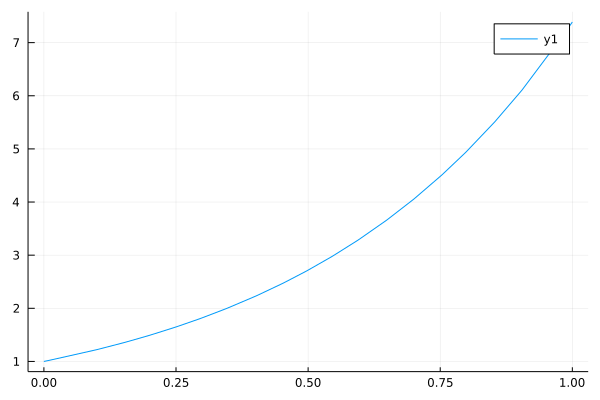

In [266]:
fakeD(t) = D₀ * exp(2t)

plot(fakeD, 0, t₁)

In [267]:
function heatflow(T, fD::Function, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = fD(t)  # compute the diffusivity at each time
            if iter == 1
                println("current D: ", D)
            end
            
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 4 methods)

current D: 1.0
current D: 1.0202013400267558
current D: 1.0408107741923882
current D: 1.0618365465453596
current D: 1.0832870676749586
current D: 1.1051709180756477
current D: 1.1274968515793757
current D: 1.1502737988572274
current D: 1.1735108709918103
current D: 1.1972173631218102
current D: 1.2214027581601699
current D: 1.2460767305873808
current D: 1.2712491503214047
current D: 1.2969300866657718
current D: 1.3231298123374369
current D: 1.3498588075760032
current D: 1.3771277643359572
current D: 1.4049475905635938
current D: 1.4333294145603404
current D: 1.4622845894342247
current D: 1.4918246976412703
current D: 1.5219615556186339
current D: 1.5527072185113362
current D: 1.584073984994482
current D: 1.6160744021928937
current D: 1.6487212707001284
current D: 1.6820276496988866
current D: 1.7160068621848588
current D: 1.7506725002961014
current D: 1.7860384307500736
current D: 1.8221188003905093
current D: 1.8589280418463425
current D: 1.896480879304952
current D: 1.93479233440203

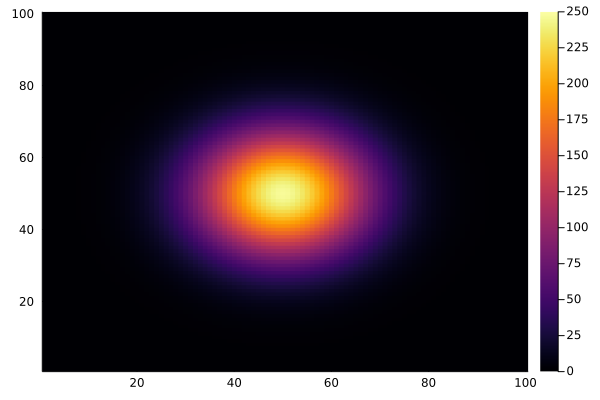

In [268]:
p = (Δx, Δy, Δt, t₁)

T₂ = copy(T₀)
T₂ = heatflow(T₂, fakeD, p, 1e-1)

heatmap(T₂, clim=(0, maximum(T₀)))

In [270]:
sqrt( sum((T₂.-T₀).^2) / (nx * ny) )

0.4581718364679681

Now, let's try to reproduce `fakeD()` with a NN.

In [271]:
function heatflow_NN(T, uD, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = uD([t]')[1]  # compute the diffusivity at each time
            #println(D)
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow_NN (generic function with 2 methods)

In [272]:
sqnorm(x) = sum(abs2, x)

function loss_NN(T, UD, p, λ=1)

    T = heatflow_NN(T, UD, p)
    l_cost = sqrt(Flux.Losses.mse(T, T₂; agg=mean))
    #l_reg  = sum(sqnorm, ps)

    return l_cost #+ λ * l_reg
end

loss_NN (generic function with 2 methods)

In [273]:
Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

function train(loss, p)
    
    leakyrelu(x, a=0.01) = max(a*x, x)
    relu(x) = max(0, x)
    sigmoid_D(x) = .5 + 10 / ( 1 + exp(-x) ) 

    #UD = Chain(
        #Dense(1,10,initb = Flux.zeros), 
        #BatchNorm(10, leakyrelu),
        #Dense(10,5,initb = Flux.zeros), 
        #BatchNorm(5, leakyrelu),
        #Dense(5,1, relu, initb = Flux.zeros) 
    #)
    UD = Chain(
        Dense(1,10,initb = Flux.glorot_normal), 
        Dense(10, 5, x->σ.(x), initb = Flux.glorot_normal),
        #BatchNorm(5, sigmoid),
        #Dense(5,1, sigmoid_D, initb = Flux.glorot_normal) 
        Dense(5, 1, x->σ.(x), initb = Flux.glorot_normal)
    )
    
    
    opt = ADAM(.5)
    losses = []
    @epochs 50 hybrid_train_NN!(loss, UD, p, opt, losses)
    
    return UD, losses
    
end

function hybrid_train_NN!(loss, UD, p, opt, losses)
    
    T = T₀
    θ = Flux.params(UD)
    loss_uD, back_uD = Zygote.pullback(() -> loss(T, UD, p), θ)
    push!(losses, loss_uD)
    
    println("Current loss: ", loss_uD)
    #println("Current parameter:", θ)
    ∇_uD = back_uD(one(loss_uD))

    #for p in θ
    #    println("Gradients ∇_uD[p]: ", ∇_uD[p])
    #end
    
    println("Values of NN: ", UD([0., .5, 1.]'))
    all_times = LinRange(0, t₁, 1000)
    #plot(all_times, UD(all_times')')
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
    
end

hybrid_train_NN! (generic function with 1 method)

In [274]:
UD_trained, losses = train(loss_NN, p)

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4099687018837024
Values of NN: Float32[0.27340052 0.28688142 0.29932672]


┌ Info: Epoch 2
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.33500963376079
Values of NN: Float32[0.74627304 0.7470065 0.7475161]


┌ Info: Epoch 3
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.30596584728282783
Values of NN: Float32[0.9304368 0.93036455 0.9303112]


┌ Info: Epoch 4
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2979917719245393
Values of NN: Float32[0.9811613 0.9812252 0.9813146]


┌ Info: Epoch 5
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29565272707802814
Values of NN: Float32[0.9945774 0.9962205 0.9977864]


┌ Info: Epoch 6
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2951406286361399
Values of NN: Float32[0.99941444 0.9994735 0.9994742]


┌ Info: Epoch 7
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950868562137827
Values of NN: Float32[0.99981135 0.9998115 0.9998115]


┌ Info: Epoch 8
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950694178834455
Values of NN: Float32[0.9999231 0.9999231 0.9999231]


┌ Info: Epoch 9
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29506284494268664
Values of NN: Float32[0.9999652 0.9999652 0.9999652]


┌ Info: Epoch 10
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29506010777597175
Values of NN: Float32[0.9999827 0.9999827 0.9999827]


┌ Info: Epoch 11
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.295058841604991
Values of NN: Float32[0.9999908 0.9999908 0.9999908]


┌ Info: Epoch 12
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505822713997576
Values of NN: Float32[0.99999475 0.99999475 0.99999475]


┌ Info: Epoch 13
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505791059746783
Values of NN: Float32[0.9999968 0.9999968 0.9999968]


┌ Info: Epoch 14
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950577243960237
Values of NN: Float32[0.999998 0.999998 0.999998]


┌ Info: Epoch 15
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505761267516795
Values of NN: Float32[0.9999987 0.9999987 0.9999987]


┌ Info: Epoch 16
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505755681474033
Values of NN: Float32[0.99999905 0.99999905 0.99999905]


┌ Info: Epoch 17
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505750095431477
Values of NN: Float32[0.9999994 0.9999994 0.9999994]


┌ Info: Epoch 18
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574823341739
Values of NN: Float32[0.9999995 0.9999995 0.9999995]


┌ Info: Epoch 19
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505746371403285
Values of NN: Float32[0.99999964 0.99999964 0.99999964]


┌ Info: Epoch 20
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505744509389126
Values of NN: Float32[0.99999976 0.99999976 0.99999976]


┌ Info: Epoch 21
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505744509389126
Values of NN: Float32[0.99999976 0.99999976 0.99999976]


┌ Info: Epoch 22
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505744509389126
Values of NN: Float32[0.99999976 0.99999976 0.99999976]


┌ Info: Epoch 23
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505742647375105
Values of NN: Float32[0.9999999 0.9999999 0.9999999]


┌ Info: Epoch 24
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505742647375105
Values of NN: Float32[0.9999999 0.9999999 0.9999999]


┌ Info: Epoch 25
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505742647375105
Values of NN: Float32[0.9999999 0.9999999 0.9999999]


┌ Info: Epoch 26
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505742647375105
Values of NN: Float32[0.9999999 0.9999999 0.9999999]


┌ Info: Epoch 27
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505742647375105
Values of NN: Float32[0.9999999 0.9999999 0.9999999]


┌ Info: Epoch 28
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505742647375105
Values of NN: Float32[0.9999999 0.9999999 0.9999999]


┌ Info: Epoch 29
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.29505742647375105
Values of NN: Float32[0.9999999 0.9999999 0.9999999]


┌ Info: Epoch 30
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 31
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 32
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 33
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 34
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 35
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 36
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 37
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 38
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 39
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 40
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 41
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 42
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 43
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 44
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 45
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 46
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 47
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 48
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 49
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


┌ Info: Epoch 50
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2950574078536103
Values of NN: Float32[1.0 1.0 1.0]


(Chain(Dense(1, 10), Dense(10, 5, #710), Dense(5, 1, #711)), Any[0.4099687018837024, 0.33500963376079, 0.30596584728282783, 0.2979917719245393, 0.29565272707802814, 0.2951406286361399, 0.2950868562137827, 0.2950694178834455, 0.29506284494268664, 0.29506010777597175  …  0.2950574078536103, 0.2950574078536103, 0.2950574078536103, 0.2950574078536103, 0.2950574078536103, 0.2950574078536103, 0.2950574078536103, 0.2950574078536103, 0.2950574078536103, 0.2950574078536103])

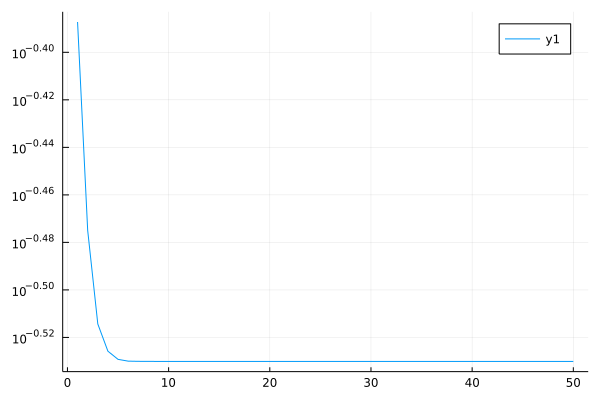

In [275]:
plot(losses, yaxis=:log)

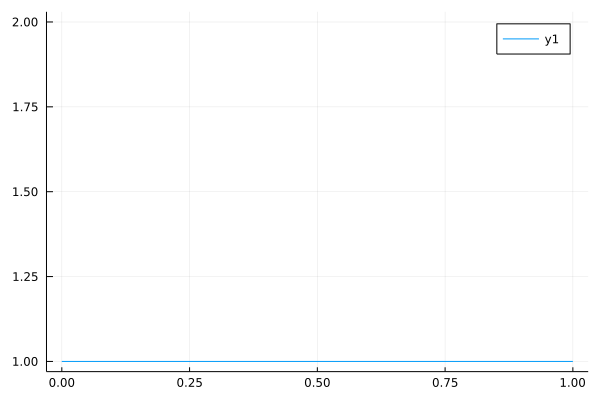

In [277]:
all_times = LinRange(0, t₁, 1000)
plot(all_times, UD_trained(all_times')')

In [230]:
sqnorm(x) = sum(abs2, x)
sum(sqnorm, Flux.params(UD))

74.07f0

In [253]:
m = Chain(
  Dense(1, 2, relu),
  Dense(2, 1))

sqnorm(x) = sum(abs2, x)

ps = Flux.params(m)   # new line

loss(x, y) = Flux.Losses.logitcrossentropy(m(x), y) + sum(sqnorm, ps)

gradient(()->loss(rand(1), rand(1)), params(m))

Grads(...)